<a href="https://colab.research.google.com/github/adams-gc/AI_SOLUTION_/blob/main/fackeMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load Dataset
!pip install --upgrade pandas


In [2]:
# !pip install pandas numpy matplotlib seaborn nltk scikit-learn tensorflow transformers
# !pip install tf-keras
# !pip install xgboost
from tensorflow import keras
from transformers import BertTokenizer, TFBertForSequenceClassification
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# XGBoost Library
from xgboost import XGBClassifier

# Transformer Model (BERT)
from transformers import BertTokenizer, TFBertForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Dataset
!pip install --upgrade pandas
import pandas as pd
import csv  # Import the csv module

# Replace 'error_bad_lines' with 'on_bad_lines'
df = pd.read_csv("/content/fake.csv", quoting=csv.QUOTE_NONNUMERIC, on_bad_lines='skip')



df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
print(df.shape)  # Rows, Columns
print(df.columns)  # Column Names


(23481, 4)
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [5]:
# Check for missing values
print(df.isnull().sum())



title      0
text       0
subject    0
date       0
dtype: int64


In [6]:
# Drop rows with missing values
df.dropna(inplace=True)


In [7]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

In [8]:
# Apply cleaning
df["cleaned_text"] = df["text"].apply(clean_text)
df.head()

nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words("english"))

# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["cleaned_text"].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:

# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df["cleaned_text"] = df["cleaned_text"].apply(remove_stopwords)


In [11]:
# Check if 'label' column exists before mapping
if 'label' in df.columns:
    # Assuming 'label' column has 'fake' and 'real' values
    df["label"] = df["label"].map({"fake": 1, "real": 0})
else:
    print("Warning: 'label' column not found in the DataFrame.")
    # Handle the missing 'label' column, e.g., add a default label or investigate data source

df.head()


,title,text,subject,date,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",donald trump wish americans happy new year lea...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",pope francis used annual christmas day message...


In [12]:
# Assuming the target variable is in the 'title' column
# and we want to classify titles containing 'trump' as '1' and others as '0'
df['label'] = df['title'].str.contains('trump', case=False).astype(int)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["label"], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)


In [13]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [14]:
# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)


In [15]:

from sklearn.naive_bayes import MultinomialNB

# Define the Naïve Bayes model
nb_model = MultinomialNB()

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Initialize Naïve Bayes model
nb_model = MultinomialNB()


In [16]:

# Train the model
nb_model.fit(X_train_tfidf, y_train)

# Get predictions
y_pred_nb = nb_model.predict(X_test_tfidf)



In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)



LogisticRegression(max_iter=1000)

In [18]:
# Get predictions
y_pred_lr = lr_model.predict(X_test_tfidf)



In [19]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [20]:
# Get predictions
y_pred_xgb = xgb_model.predict(X_test_tfidf)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=3000, output_dim=128, input_length=200),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [22]:
# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define the parameter grid
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Perform GridSearchCV
grid_search_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, scoring='accuracy', cv=5)
grid_search_nb.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_nb_model = grid_search_nb.best_estimator_
print("Best Parameters for Naïve Bayes:", grid_search_nb.best_params_)

Best Parameters for Naïve Bayes: {'alpha': 2.0}


In [23]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Solvers to try
}



In [24]:
# Perform GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [25]:
# Get the best parameters and model
best_lr_model = grid_search_lr.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)


Best Parameters for Logistic Regression: {'C': 10, 'solver': 'saga'}


In [26]:
# Define XGBoost parameter grid
param_grid_xgb = {
    'max_depth': [2, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='accuracy', cv=2)
grid_search_xgb.fit(X_train_tfidf, y_train)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [27]:

# Get the best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)



Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [29]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [34]:
import keras_tuner as kt

def build_lstm_model(hp):
    # Increased input_dim to 5000 to match the Tokenizer num_words
    model = Sequential([
        Embedding(input_dim=5000, output_dim=hp.Int("embedding_dim", 64, 128, step=32), input_length=200),
        LSTM(hp.Int("lstm_units", 50, 150, step=50), return_sequences=True),
        LSTM(hp.Int("lstm_units2", 25, 100, step=25)),
        Dense(hp.Int("dense_units", 32, 128, step=32), activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        metrics=['accuracy']
    )
    return model

In [35]:

# Initialize KerasTuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=5,
    directory='lstm_tuning',
    project_name='fake_news_lstm'
)

# Run the tuning
tuner.search(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

Trial 5 Complete [00h 06m 54s]
val_accuracy: 0.8677879571914673

Best val_accuracy So Far: 0.8705556988716125
Total elapsed time: 00h 24m 12s


In [36]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters for LSTM:", best_hps.values)


Best Hyperparameters for LSTM: {'embedding_dim': 64, 'lstm_units': 50, 'lstm_units2': 25, 'dense_units': 64, 'learning_rate': 0.0001}


In [37]:
# LSTM Model Architecture after Hyperparameter Tuning
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=best_hps['embedding_dim'], input_length=200),
    LSTM(best_hps['lstm_units'], return_sequences=True),
    LSTM(best_hps['lstm_units2']),
    Dense(best_hps['dense_units'], activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_hps['learning_rate']), metrics=['accuracy'])
lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.6360 - loss: 0.6503 - val_accuracy: 0.8448 - val_loss: 0.3868
Epoch 2/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.8637 - loss: 0.3553 - val_accuracy: 0.8625 - val_loss: 0.3513
Epoch 3/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.8941 - loss: 0.3011 - val_accuracy: 0.8661 - val_loss: 0.3410
Epoch 4/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 74s 139ms/step - accuracy: 0.9120 - loss: 0.2665 - val_accuracy: 0.8699 - val_loss: 0.3454
Epoch 5/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.9149 - loss: 0.2556 - val_accuracy: 0.8731 - val_loss: 0.3387


In [38]:
# Predictions
y_pred_nb = best_nb_model.predict(X_test_tfidf)
y_pred_lr = best_lr_model.predict(X_test_tfidf)
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")


147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [39]:
# Evaluation
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))

Naïve Bayes Accuracy: 0.7943368107302533
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2904
           1       0.75      0.70      0.72      1793

    accuracy                           0.79      4697
   macro avg       0.78      0.78      0.78      4697
weighted avg       0.79      0.79      0.79      4697

Logistic Regression Accuracy: 0.8750266127315308
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2904
           1       0.86      0.81      0.83      1793

    accuracy                           0.88      4697
   macro avg       0.87      0.86      0.87      4697
weighted avg       0.87      0.88      0.87      4697

XGBoost Accuracy: 0.897594209069619
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2904
           1       0.87      0.87      0.87      1793

    accuracy                           0.90      4697
  

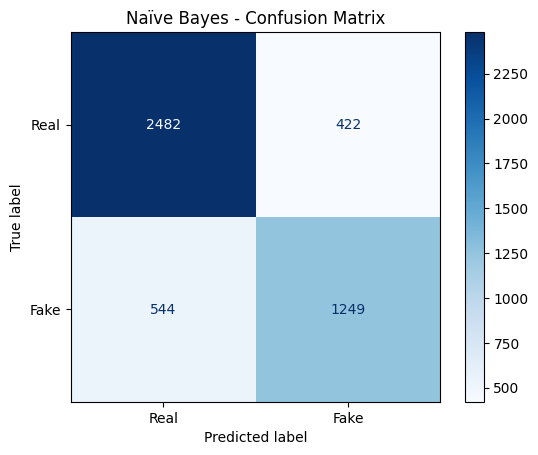

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix for Naïve Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Real', 'Fake'])
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("Naïve Bayes - Confusion Matrix")
plt.show()

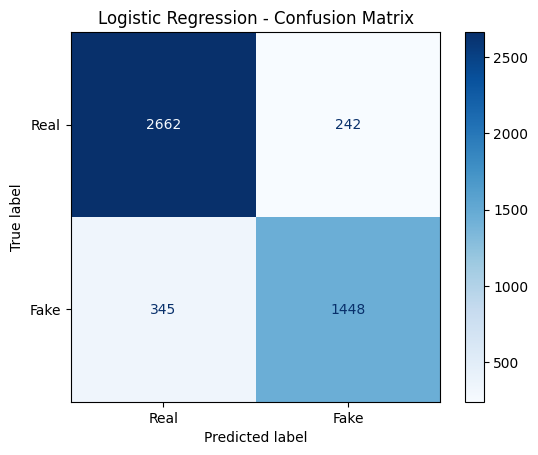

In [41]:

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Real', 'Fake'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

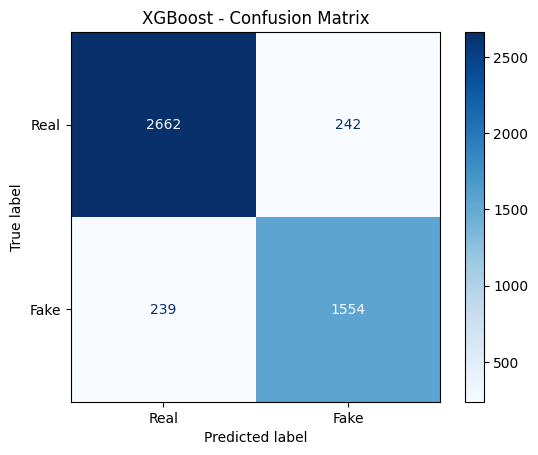

In [42]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Real', 'Fake'])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("XGBoost - Confusion Matrix")
plt.show()


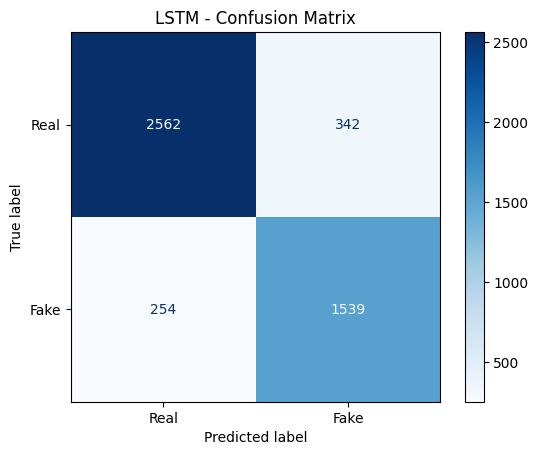

In [43]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Real', 'Fake'])
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title("LSTM - Confusion Matrix")
plt.show()


In [44]:
import pandas as pd

# Collecting evaluation metrics for all models
nb_metrics = classification_report(y_test, y_pred_nb, output_dict=True)
lr_metrics = classification_report(y_test, y_pred_lr, output_dict=True)
xgb_metrics = classification_report(y_test, y_pred_xgb, output_dict=True)
lstm_metrics = classification_report(y_test, y_pred_lstm, output_dict=True)


In [45]:
# Extracting relevant metrics (Accuracy, Precision, Recall, F1-Score)
models = ['Naïve Bayes', 'Logistic Regression', 'XGBoost', 'LSTM']

# Initialize lists to hold the metric values
accuracy = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_lstm)
]

precision_fake = [
    nb_metrics['0']['precision'],
    lr_metrics['0']['precision'],
    xgb_metrics['0']['precision'],
    lstm_metrics['0']['precision']
]

precision_real = [
    nb_metrics['1']['precision'],
    lr_metrics['1']['precision'],
    xgb_metrics['1']['precision'],
    lstm_metrics['1']['precision']
]

recall_fake = [
    nb_metrics['0']['recall'],
    lr_metrics['0']['recall'],
    xgb_metrics['0']['recall'],
    lstm_metrics['0']['recall']
]

recall_real = [
    nb_metrics['1']['recall'],
    lr_metrics['1']['recall'],
    xgb_metrics['1']['recall'],
    lstm_metrics['1']['recall']
]

f1_fake = [
    nb_metrics['0']['f1-score'],
    lr_metrics['0']['f1-score'],
    xgb_metrics['0']['f1-score'],
    lstm_metrics['0']['f1-score']
]

f1_real = [
    nb_metrics['1']['f1-score'],
    lr_metrics['1']['f1-score'],
    xgb_metrics['1']['f1-score'],
    lstm_metrics['1']['f1-score']
]

# Creating a DataFrame for better visualization
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision (Fake)': precision_fake,
    'Recall (Fake)': recall_fake,
    'F1-Score (Fake)': f1_fake,
    'Precision (Real)': precision_real,
    'Recall (Real)': recall_real,
    'F1-Score (Real)': f1_real
})

In [46]:
# Display the comparison DataFrame
print(comparison_df)

                 Model  Accuracy  Precision (Fake)  Recall (Fake)  \
0          Naïve Bayes  0.794337          0.820225       0.854683   
1  Logistic Regression  0.875027          0.885268       0.916667   
2              XGBoost  0.897594          0.917615       0.916667   
3                 LSTM  0.873110          0.909801       0.882231   

   F1-Score (Fake)  Precision (Real)  Recall (Real)  F1-Score (Real)  
0         0.837099          0.747457       0.696598         0.721132  
1         0.900694          0.856805       0.807585         0.831467  
2         0.917140          0.865256       0.866704         0.865979  
3         0.895804          0.818182       0.858338         0.837779  


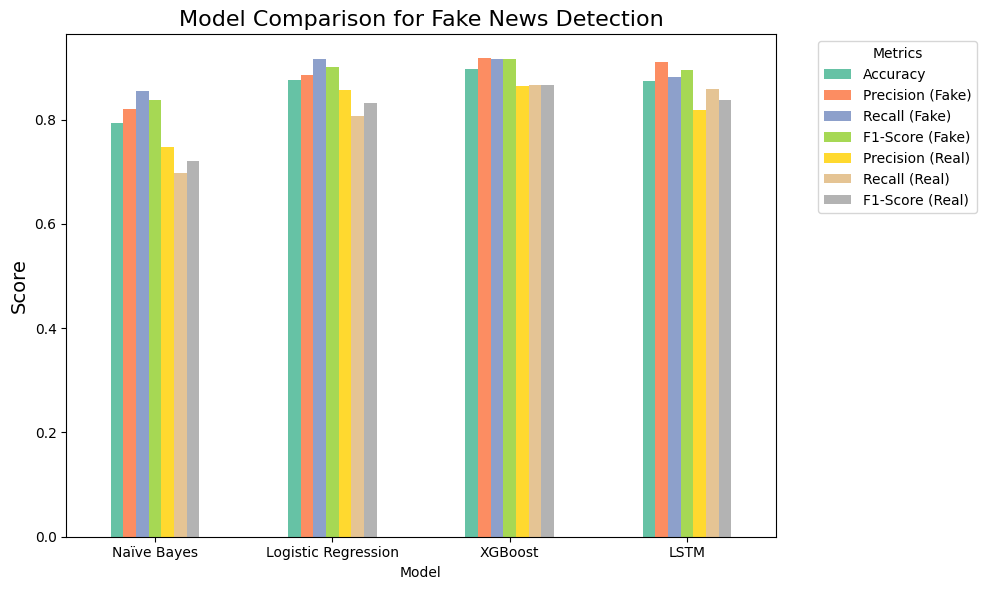

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the comparison
comparison_df.set_index('Model', inplace=True)
comparison_df.plot(kind='bar', figsize=(10,6), colormap='Set2')

# Adding titles and labels
plt.title('Model Comparison for Fake News Detection', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [48]:

models = ["Naïve Bayes", "Logistic Regression", "XGBoost", "LSTM"]
accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_lstm)
]


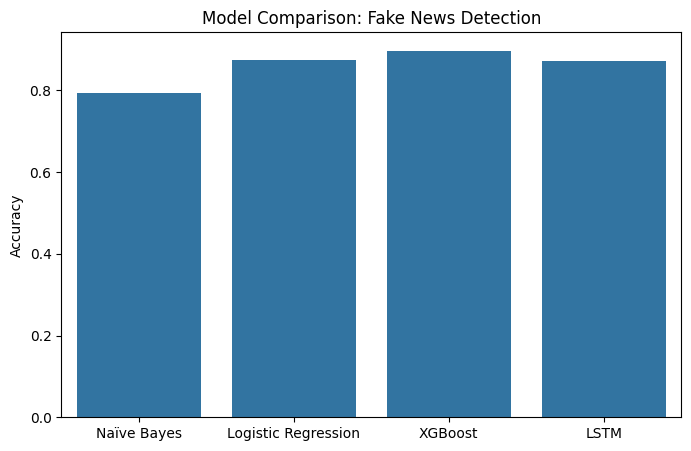

In [49]:
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies)
plt.title("Model Comparison: Fake News Detection")
plt.ylabel("Accuracy")
plt.show()

In [50]:

# ROC Curve & AUC for all models
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)

auc_nb = auc(fpr_nb, tpr_nb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lstm = auc(fpr_lstm, tpr_lstm)


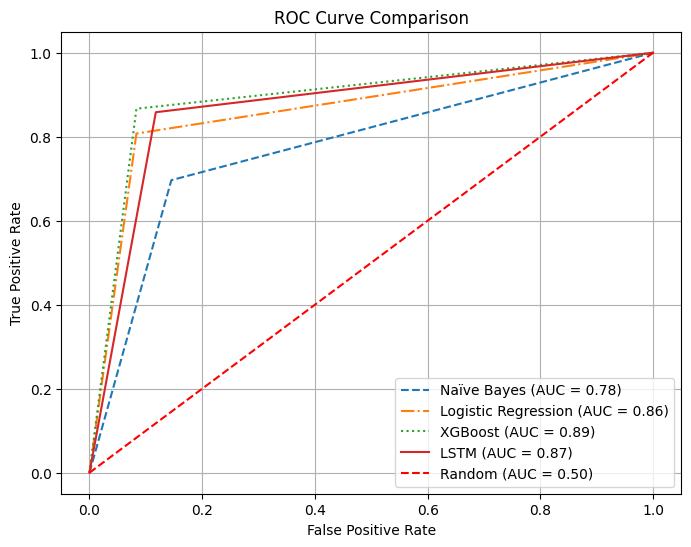

In [51]:
# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_nb, tpr_nb, label=f'Naïve Bayes (AUC = {auc_nb:.2f})', linestyle='--')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linestyle='-.')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linestyle=':')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})', linestyle='-')
plt.plot([0, 1], [0, 1], 'r--', label='Random (AUC = 0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [52]:
# Save LSTM Model in Keras format (.keras)
lstm_model.save('lstm_model.keras')


In [53]:
import joblib

# Save Naïve Bayes Model
joblib.dump(nb_model, 'naive_bayes_model.pkl')

# Save Logistic Regression Model
joblib.dump(lr_model, 'logistic_regression_model.pkl')

# Save XGBoost Model
joblib.dump(best_xgb_model, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [54]:
# Save LSTM Model in Keras format (.keras)
lstm_model.save('lstm_model.keras')

print("Models saved successfully.")

Models saved successfully.
